In [2]:
import re
DATAFILE_PATTERN = '^(.+),"(.+)",(.*),(.*),(.*)'
from pyspark import SparkContext
sc =SparkContext()

def removeQuotes(s):
    return ''.join(i for i in s if i!='"')


def parseDatafileLine(datafileLine):
    match = re.search(DATAFILE_PATTERN, datafileLine)
    if match is None:
        print 'Invalid datafile line: %s' % datafileLine
        return (datafileLine, -1)
    elif match.group(1) == '"id"':
        print 'Header datafile line: %s' % datafileLine
        return (datafileLine, 0)
    else:
        product = '%s %s %s' % (match.group(2), match.group(3), match.group(4))
        return ((removeQuotes(match.group(1)), product), 1)

In [3]:
import sys
import os
from test_helper import Test

baseDir = os.path.join('data')
inputPath = os.path.join('products')

GOOGLE_PATH = 'google.csv'
GOOGLE_SMALL_PATH = 'google.csv'
AMAZON_PATH = 'amazon.csv'
AMAZON_SMALL_PATH = 'amazon.csv'
GOLD_STANDARD_PATH = 'perfect_mapping.csv'
STOPWORDS_PATH = 'stopwords.csv'

def parseData(filename):
    return (sc.textFile(filename, minPartitions=4, use_unicode=False).map(parseDatafileLine))

def loadData(path):

    filename = os.path.join(baseDir, inputPath, path)
    raw = parseData(filename).cache()
    failed = (raw.filter(lambda s: s[1] == -1).map(lambda s: s[0]))
    for line in failed.take(10):
        print '%s - Invalid datafile line: %s' % (path, line)
        
    valid = (raw.filter(lambda s: s[1] == 1).map(lambda s: s[0]).cache())
    print '%s - Read %d lines, successfully parsed %d lines, failed to parse %d lines' % \
    (path, raw.count(), valid.count(), failed.count())
    assert failed.count() == 0
    assert raw.count() == (valid.count() + 1)
    return valid

googleSmall = loadData(GOOGLE_SMALL_PATH)
google = loadData(GOOGLE_PATH)
amazonSmall = loadData(AMAZON_SMALL_PATH)
amazon = loadData(AMAZON_PATH)

google.csv - Read 3227 lines, successfully parsed 3226 lines, failed to parse 0 lines
google.csv - Read 3227 lines, successfully parsed 3226 lines, failed to parse 0 lines
amazon.csv - Read 1364 lines, successfully parsed 1363 lines, failed to parse 0 lines
amazon.csv - Read 1364 lines, successfully parsed 1363 lines, failed to parse 0 lines


In [4]:
for line in googleSmall.take(3):
    print 'google: %s: %s\n' % (line[0], line[1])

for line in amazonSmall.take(3):
    print 'amazon: %s: %s\n' % (line[0], line[1])

google: http://www.google.com/base/feeds/snippets/11125907881740407428: learning quickbooks 2007 "learning quickbooks 2007" "intuit"

google: http://www.google.com/base/feeds/snippets/11538923464407758599: superstart! fun with reading & writing! "fun with reading & writing! is designed to help kids learn to read and write better through exercises puzzle-solving creative writing decoding and more!" 

google: http://www.google.com/base/feeds/snippets/11343515411965421256: qb pos 6.0 basic software "qb pos 6.0 basic retail mngmt software. for retailers who need basic inventory sales and customer tracking." "intuit"

amazon: b000jz4hqo: clickart 950 000 - premier image pack (dvd-rom)  "broderbund"

amazon: b0006zf55o: ca international - arcserve lap/desktop oem 30pk "oem arcserve backup v11.1 win 30u for laptops and desktops" "computer associates"

amazon: b00004tkvy: noah's ark activity center (jewel case ages 3-8)  "victory multimedia"



In [5]:
quickbrownfox = 'A quick brown fox jumps over the lazy dog.'
split_regex = r'\W+'

def simpleTokenize(string):
    """ A simple implementation of input string tokenization
    Args:
        string (str): input string
    Returns:
        list: a list of tokens
    """
    return filter(lambda x: len(x) > 0, re.split(split_regex, string.lower()))

print simpleTokenize(quickbrownfox) # Should give ['a', 'quick', 'brown', ... ]

['a', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']


In [6]:
Test.assertEquals(simpleTokenize(quickbrownfox),
                  ['a','quick','brown','fox','jumps','over','the','lazy','dog'],
                  'simpleTokenize should handle sample text')
Test.assertEquals(simpleTokenize(' '), [], 'simpleTokenize should handle empty string')
Test.assertEquals(simpleTokenize('!!!!123A/456_B/789C.123A'), ['123a','456_b','789c','123a'],
                  'simpleTokenize should handle punctuations and lowercase result')
Test.assertEquals(simpleTokenize('fox fox'), ['fox', 'fox'],
                  'simpleTokenize should not remove duplicates')

1 test passed.
1 test passed.
1 test passed.
1 test passed.


In [16]:
stopfile = os.path.join(baseDir, inputPath, STOPWORDS_PATH)
stopwords = set(sc.textFile(stopfile).collect())
#print 'These are the stopwords: %s' % stopwords

def tokenize(string):
    """ An implementation of input string tokenization that excludes stopwords
    Args:
        string (str): input string
    Returns:
        list: a list of tokens without stopwords
    """
    return filter(lambda x: x.lower() not in stopwords, simpleTokenize(string))

print tokenize(quickbrownfox) # Should give ['quick', 'brown', ... ]


['quick', 'brown', 'fox', 'jumps', 'lazy', 'dog']


In [17]:
Test.assertEquals(tokenize("Why a the?"), [], 'tokenize should remove all stopwords')
Test.assertEquals(tokenize("Being at the_?"), ['the_'], 'tokenize should handle non-stopwords')
Test.assertEquals(tokenize(quickbrownfox), ['quick','brown','fox','jumps','lazy','dog'],
                    'tokenize should handle sample text')


1 test passed.
1 test passed.
1 test passed.


In [18]:
amazonRecToToken = amazonSmall.map(lambda s: (s[0], tokenize(s[1])))
googleRecToToken = googleSmall.map(lambda s: (s[0], tokenize(s[1])))

def countTokens(vendorRDD):
    """ Count and return the number of tokens
    Args:
        vendorRDD (RDD of (recordId, tokenizedValue)): Pair tuple of record ID to tokenized output
    Returns:
        count: count of all tokens
    """
    tokenCount = vendorRDD.map(lambda s: len(s[1])).reduce(lambda a, b : a + b)
    return tokenCount

totalTokens = countTokens(amazonRecToToken) + countTokens(googleRecToToken)
print 'There are %s tokens in the combined datasets' % totalTokens

There are 264149 tokens in the combined datasets


In [19]:
def findBiggestRecord(vendorRDD):
    """ Find and return the record with the largest number of tokens
    Args:
        vendorRDD (RDD of (recordId, tokens)): input Pair Tuple of record ID and tokens
    Returns:
        list: a list of 1 Pair Tuple of record ID and tokens
    """
    return vendorRDD.takeOrdered(1, lambda s: -1 * len(s[1]))

biggestRecordAmazon = findBiggestRecord(amazonRecToToken)
print 'The Amazon record with ID "%s" has the most tokens (%s)' % (biggestRecordAmazon[0][0],
                                                                   len(biggestRecordAmazon[0][1]))

The Amazon record with ID "b000ndibqy" has the most tokens (1915)


In [20]:
def tf(tokens):
    """ Compute TF
    Args:
        tokens (list of str): input list of tokens from tokenize
    Returns:
        dictionary: a dictionary of tokens to its TF values
    """
    counts = {}
    for key in tokens:
      if key in counts:
        counts[key] += 1
      else:
        counts[key] = 1
    n_tokens = len(tokens)
    
    freq = {}
    for k,v in counts.items():
      freq[k] = 1.0*v/ n_tokens 
    return freq
    #return { t: counts[t] / n_tokens for t in counts }

print tf(tokenize(quickbrownfox)) # Should give { 'quick': 0.1666 ... }

{'brown': 0.16666666666666666, 'lazy': 0.16666666666666666, 'jumps': 0.16666666666666666, 'fox': 0.16666666666666666, 'dog': 0.16666666666666666, 'quick': 0.16666666666666666}


In [23]:
tf_test = tf(tokenize(quickbrownfox))
Test.assertEquals(tf_test, {'brown': 0.16666666666666666, 'lazy': 0.16666666666666666,
                             'jumps': 0.16666666666666666, 'fox': 0.16666666666666666,
                             'dog': 0.16666666666666666, 'quick': 0.16666666666666666},
                    'incorrect result for tf on sample text')
tf_test2 = tf(tokenize('one_ one_ two!'))
Test.assertEquals(tf_test2, {'one_': 0.6666666666666666, 'two': 0.3333333333333333},
                    'incorrect result for tf test')

1 test passed.
1 test passed.


In [28]:
corpusRDD = amazonRecToToken.union(googleRecToToken)
Test.assertEquals(corpusRDD.count(), 4589, 'incorrect corpusRDD.count()')

1 test passed.


In [29]:
def idfs(corpus):
    """ Compute IDF
    Args:
        corpus (RDD): input corpus
    Returns:
        RDD: a RDD of (token, IDF value)
    """
    N = float(corpus.count())
    uniqueTokens = corpus.flatMap(lambda s: list(set(s[1])))
    tokenCountPairTuple = uniqueTokens.map(lambda token: (token, 1))
    tokenSumPairTuple = tokenCountPairTuple.reduceByKey(lambda a, b : a + b)
    return (tokenSumPairTuple.map(lambda s: (s[0], float(N/s[1]))))


idfsSmall = idfs(amazonRecToToken.union(googleRecToToken))
uniqueTokenCount = idfsSmall.count()

print 'There are %s unique tokens in the small datasets.' % uniqueTokenCount

There are 16790 unique tokens in the small datasets.


In [34]:
Test.assertEquals(uniqueTokenCount, 16790, 'incorrect uniqueTokenCount')
tokenSmallestIdf = idfsSmall.takeOrdered(1, lambda s: s[1])[0]
Test.assertEquals(tokenSmallestIdf[0], 'software', 'incorrect smallest IDF token')
Test.assertTrue(abs(tokenSmallestIdf[1] -  2.472521551724138) < 0.0000000001,
                'incorrect smallest IDF value')

1 test passed.
1 test passed.
1 test passed.


In [35]:
smallIDFTokens = idfsSmall.takeOrdered(11, lambda s: s[1])
print smallIDFTokens

[('software', 2.472521551724138), ('mac', 5.616891064871481), ('windows', 6.3647711511789185), ('system', 6.748529411764705), ('features', 7.038343558282208), ('complete', 7.725589225589226), ('easy', 8.283393501805055), ('pc', 8.74095238095238), ('win', 9.033464566929133), ('time', 9.50103519668737), ('professional', 9.620545073375261)]


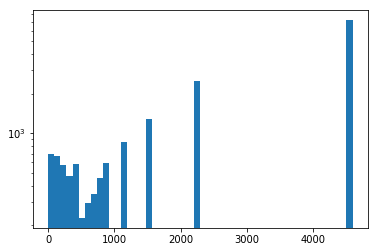

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display

small_idf_values = idfsSmall.map(lambda s: s[1]).collect()

plt.hist(small_idf_values, 50, log=True)

pass

In [67]:
from pyspark.sql import Row,SQLContext

sqlContext = SQLContext(sc)

# Create a DataFrame and visualize using display()
idfsToCountRow = idfsSmall.map(lambda (x, y): Row(token=x, value=y))
idfsToCountDF = sqlContext.createDataFrame(idfsToCountRow)
idfsToCountDF.show()

+------------------+------------------+
|             token|             value|
+------------------+------------------+
|         paperless|            4589.0|
|             aided|             917.8|
|         promenade|            4589.0|
|presentationsimply|            4589.0|
|              fawn|            4589.0|
|          believed|            4589.0|
|            resist|            4589.0|
|            joshua|            4589.0|
|             catch|          286.8125|
|           ableton| 764.8333333333334|
|           mansion| 655.5714285714286|
|     relationships|305.93333333333334|
|          increase| 86.58490566037736|
|             paris| 764.8333333333334|
|           desiree|            4589.0|
|       quarkxpress| 417.1818181818182|
|       multiplexor|            2294.5|
|           recycle|           1147.25|
|        summarizes|            2294.5|
|               mlb|1529.6666666666667|
+------------------+------------------+
only showing top 20 rows



In [68]:
def tfidf(tokens, idfs):
    """ Compute TF-IDF
    Args:
        tokens (list of str): input list of tokens from tokenize
        idfs (dictionary): record to IDF value
    Returns:
        dictionary: a dictionary of records to TF-IDF values
    """
#     tfs = <FILL IN>
#     tfIdfDict = <FILL IN>
    tfs = tf(tokens)
    tfIdfDict = { t: tfs[t] * idfs[t] for t in tfs }
    return tfIdfDict

recb000hkgj8k = amazonRecToToken.filter(lambda x: x[0] == 'b000hkgj8k').collect()[0][1]
idfsSmallWeights = idfsSmall.collectAsMap()
rec_b000hkgj8k_weights = tfidf(recb000hkgj8k, idfsSmallWeights)

print 'Amazon record "b000hkgj8k" has tokens and weights:\n%s' % rec_b000hkgj8k_weights

Amazon record "b000hkgj8k" has tokens and weights:
{'autocad': 152.96666666666664, 'autodesk': 23.901041666666664, 'courseware': 152.96666666666664, 'psg': 95.60416666666666, '2007': 2.908111533586818, 'customizing': 76.48333333333332, 'interface': 3.9835069444444446}


In [69]:
import math

def dotprod(a, b):
    """ Compute dot product
    Args:
        a (dictionary): first dictionary of record to value
        b (dictionary): second dictionary of record to value
    Returns:
        dotProd: result of the dot product with the two input dictionaries
    """
    return sum([a[t] * b[t] for t in a if t in b])

def norm(a):
    """ Compute square root of the dot product
    Args: a (dictionary): a dictionary of record to value
    Returns: norm (float): the square root of the dot product value """

    return math.sqrt(dotprod(a, a))

def cossim(a, b):
    """ Compute cosine similarity
    Args:
        a (dictionary): first dictionary of record to value
        b (dictionary): second dictionary of record to value
    Returns:
        cossim: dot product of two dictionaries divided by the norm of the first dictionary and
                then by the norm of the second dictionary
    """
    #return <FILL IN>
    return dotprod(a, b) / norm(a) / norm(b)

testVec1 = {'foo': 2, 'bar': 3, 'baz': 5 }
testVec2 = {'foo': 1, 'bar': 0, 'baz': 20 }
dp = dotprod(testVec1, testVec2)
nm = norm(testVec1)
print dp, nm

102 6.16441400297


In [73]:
def cosineSimilarity(string1, string2, idfsDictionary):
    """ Compute cosine similarity between two strings
    Args:
        string1 (str): first string
        string2 (str): second string
        idfsDictionary (dictionary): a dictionary of IDF values
    Returns:
        cossim: cosine similarity value
    """
#     w1 = tfidf(<FILL IN>)
#     w2 = tfidf(<FILL IN>)
    w1 = tfidf(tokenize(string1), idfsDictionary)
    w2 = tfidf(tokenize(string2), idfsDictionary)    
    return cossim(w1, w2)

cossimAdobe = cosineSimilarity('Adobe Photoshop',
                               'Adobe Illustrator',
                               idfsSmallWeights)

print cossimAdobe


0.0864190021024


In [74]:
crossSmall = (googleSmall.cartesian(amazonSmall).cache())
              

def computeSimilarity(record):
    """ Compute similarity on a combination record
    Args:
        record: a pair, (google record, amazon record)
    Returns:
        pair: a pair, (google URL, amazon ID, cosine similarity value)
    """

    googleRec = record[0]
    amazonRec = record[1]
    googleURL = googleRec[0]
    amazonID = amazonRec[0]
    googleValue = googleRec[1]
    amazonValue = amazonRec[1]
    cs = cosineSimilarity(googleValue, amazonValue, idfsSmallWeights)
    return (googleURL, amazonID, cs)  

similarities = (crossSmall.map(computeSimilarity).cache())
                

def similar(amazonID, googleURL):
    """ Return similarity value
    Args:
        amazonID: amazon ID
        googleURL: google URL
    Returns:
        similar: cosine similarity value
    """
    return (similarities
            .filter(lambda record: (record[0] == googleURL and record[1] == amazonID))
            .collect()[0][2])

similarityAmazonGoogle = similar('b000o24l3q', 'http://www.google.com/base/feeds/snippets/17242822440574356561')
print 'Requested similarity is %s.' % similarityAmazonGoogle

Requested similarity is 1.44022871999e-05.


In [76]:
def computeSimilarityBroadcast(record):
    """ Compute similarity on a combination record, using Broadcast variable
    Args:
        record: a pair, (google record, amazon record)
    Returns:
        pair: a pair, (google URL, amazon ID, cosine similarity value)
    """
    googleRec = record[0]
    amazonRec = record[1]
    googleURL = googleRec[0]
    amazonID = amazonRec[0]
    googleValue = googleRec[1]
    amazonValue = amazonRec[1]
    cs = cosineSimilarity(googleValue, amazonValue, idfsSmallWeights)
    return (googleURL, amazonID, cs)
  

idfsSmallBroadcast = sc.broadcast(idfsSmallWeights)
similaritiesBroadcast = (crossSmall
                         .map(computeSimilarityBroadcast)
                         .cache())

def similarBroadcast(amazonID, googleURL):
    """ Return similarity value, computed using Broadcast variable
    Args:
        amazonID: amazon ID
        googleURL: google URL
    Returns:
        similar: cosine similarity value
    """
    return (similaritiesBroadcast
            .filter(lambda record: (record[0] == googleURL and record[1] == amazonID))
            .collect()[0][2])

similarityAmazonGoogleBroadcast = similarBroadcast('b000o24l3q', 'http://www.google.com/base/feeds/snippets/17242822440574356561')
print 'Requested similarity is %s.' % similarityAmazonGoogleBroadcast

Requested similarity is 1.44022871999e-05.


In [77]:
GOLDFILE_PATTERN = '^(.+),(.+)'

# Parse each line of a data file useing the specified regular expression pattern
def parse_goldfile_line(goldfile_line):

    match = re.search(GOLDFILE_PATTERN, goldfile_line)
    if match is None:
        print 'Invalid goldfile line: %s' % goldfile_line
        return (goldfile_line, -1)
    elif match.group(1) == '"idAmazon"':
        print 'Header datafile line: %s' % goldfile_line
        return (goldfile_line, 0)
    else:
        key = '%s %s' % (removeQuotes(match.group(1)), removeQuotes(match.group(2)))
        return ((key, 'gold'), 1)

goldfile = os.path.join(baseDir, inputPath, GOLD_STANDARD_PATH)
gsRaw = (sc
         .textFile(goldfile)
         .map(parse_goldfile_line)
         .cache())

gsFailed = (gsRaw
            .filter(lambda s: s[1] == -1)
            .map(lambda s: s[0]))
for line in gsFailed.take(10):
    print 'Invalid goldfile line: %s' % line

goldStandard = (gsRaw
                .filter(lambda s: s[1] == 1)
                .map(lambda s: s[0])
                .cache())

print 'Read %d lines, successfully parsed %d lines, failed to parse %d lines' % (gsRaw.count(),
                                                                                 goldStandard.count(),
                                                                                 gsFailed.count())
assert (gsFailed.count() == 0)
assert (gsRaw.count() == (goldStandard.count() + 1))

Read 1301 lines, successfully parsed 1300 lines, failed to parse 0 lines


In [78]:
sims = similaritiesBroadcast.map(lambda x: ("%s %s" % (x[1], x[0]), x[2]))

trueDupsRDD = (sims.join(goldStandard).map(lambda a: a[1][0]))

trueDupsCount = trueDupsRDD.count()

avgSimDups = float(trueDupsRDD.reduce(lambda a, b: a + b)) / float(trueDupsCount)

nonDupsRDD = (sims
              .leftOuterJoin(goldStandard)
              .filter(lambda x: (x[1][1] is None))
              .map(lambda a: a[1][0]))
avgSimNon = float(nonDupsRDD.reduce(lambda a, b: a + b)) / float(sims.count() - trueDupsCount)

print 'There are %s true duplicates.' % trueDupsCount
print 'The average similarity of true duplicates is %s.' % avgSimDups
print 'And for non duplicates, it is %s.' % avgSimNon

There are 1300 true duplicates.
The average similarity of true duplicates is 0.216648049591.
And for non duplicates, it is 0.000392067453142.


In [79]:
amazonFullRecToToken = amazon.map(lambda s: (s[0], tokenize(s[1])))
googleFullRecToToken = google.map(lambda s: (s[0], tokenize(s[1])))
print 'Amazon full dataset is %s products, Google full dataset is %s products' % (amazonFullRecToToken.count(),
                                                                                    googleFullRecToToken.count())

Amazon full dataset is 1363 products, Google full dataset is 3226 products


In [80]:
fullCorpusRDD = amazonFullRecToToken.union(googleFullRecToToken)

idfsFull = idfs(fullCorpusRDD)
idfsFullCount = idfsFull.count()
print 'There are %s unique tokens in the full datasets.' % idfsFullCount

# Recompute IDFs for full dataset
# idfsFullWeights = <FILL IN>
# idfsFullBroadcast = <FILL IN>
idfsFullWeights = idfsFull.collectAsMap()
idfsFullBroadcast = sc.broadcast(idfsFullWeights)
# Pre-compute TF-IDF weights.  Build mappings from record ID weight vector.
# amazonWeightsRDD = <FILL IN>
# googleWeightsRDD = <FILL IN>
amazonWeightsRDD = amazonFullRecToToken.map(lambda x: (x[0], tfidf(x[1], idfsFullBroadcast.value)))
googleWeightsRDD = googleFullRecToToken.map(lambda x: (x[0], tfidf(x[1], idfsFullBroadcast.value)))

print 'There are %s Amazon weights and %s Google weights.' % (amazonWeightsRDD.count(),
                                                              googleWeightsRDD.count())

There are 16790 unique tokens in the full datasets.
There are 1363 Amazon weights and 3226 Google weights.


In [81]:
amazonNorms = amazonWeightsRDD.map(lambda x: (x[0], norm(x[1]))).collectAsMap()
amazonNormsBroadcast = sc.broadcast(amazonNorms)
googleNorms = googleWeightsRDD.map(lambda x: (x[0], norm(x[1]))).collectAsMap()
googleNormsBroadcast = sc.broadcast(googleNorms)

In [84]:
def invert(record):
    """ Invert (ID, tokens) to a list of (token, ID)
    Args:
        record: a pair, (ID, token vector)
    Returns:
        pairs: a list of pairs of token to ID
    """
#     <FILL IN>
#     return (pairs)
    value = record[0]
    keys = record[1].keys()
    pairs = []
    for key in keys:
        pairs.append((key, value))
    return (pairs)
  
# amazonInvPairsRDD = (amazonWeightsRDD
#                     .<FILL IN>
#                     .cache())

# googleInvPairsRDD = (googleWeightsRDD
#                     .<FILL IN>
#                     .cache())

#why flatmap?
amazonInvPairsRDD = (amazonWeightsRDD.flatMap(invert).cache())
googleInvPairsRDD = (googleWeightsRDD.flatMap(invert).cache())

print 'There are %s Amazon inverted pairs and %s Google inverted pairs.' % (amazonInvPairsRDD.count(),
                                                                            googleInvPairsRDD.count())

There are 98644 Amazon inverted pairs and 68527 Google inverted pairs.


In [89]:
def swap(record):
    """ Swap (token, (ID, URL)) to ((ID, URL), token)
    Args:
        record: a pair, (token, (ID, URL))
    Returns:
        pair: ((ID, URL), token)
    """
    token = record[0]
    keys = (record[1][0], record[1][1])
    return (keys, token)
  

commonTokens = (amazonInvPairsRDD.join(googleInvPairsRDD)
                                 .map(swap)
                                 .groupByKey()
                                 .map(lambda rec: (rec[0], list(rec[1])))
                                 .cache())

print 'Found %d common tokens' % commonTokens.count()


Found 2161805 common tokens


In [91]:
amazonWeightsBroadcast = sc.broadcast(amazonWeightsRDD.collectAsMap())
googleWeightsBroadcast = sc.broadcast(googleWeightsRDD.collectAsMap())


def fastCosineSimilarity(record):
    """ Compute Cosine Similarity using Broadcast variables
    Args:
        record: ((ID, URL), token)
    Returns:
        pair: ((ID, URL), cosine similarity value)
    """

    amazonRec = record[0][0]
    googleRec = record[0][1]
    tokens = record[1]
    s = sum([amazonWeightsBroadcast.value[amazonRec][t] * googleWeightsBroadcast.value[googleRec][t]
             for t in tokens])
    value = s / googleNormsBroadcast.value[googleRec] / amazonNormsBroadcast.value[amazonRec]
    key = (amazonRec, googleRec)
    return (key, value)
  
# similaritiesFullRDD = (commonTokens
#                        .<FILL IN>
#                        .cache())
similaritiesFullRDD = (commonTokens
                       .map(fastCosineSimilarity)
                       .cache())

print similaritiesFullRDD.count()

2161805


In [94]:
# Create an RDD of ((Amazon ID, Google URL), similarity score)
simsFullRDD = similaritiesFullRDD.map(lambda x: ("%s %s" % (x[0][0], x[0][1]), x[1]))
assert (simsFullRDD.count() == 2161805)

# Create an RDD of just the similarity scores
simsFullValuesRDD = (simsFullRDD
                     .map(lambda x: x[1])
                     .cache())
assert (simsFullValuesRDD.count() == 2161805)

# Look up all similarity scores for true duplicates

# This helper function will return the similarity score for records that are in the gold standard and the simsFullRDD (True positives), and will return 0 for records that are in the gold standard but not in simsFullRDD (False Negatives).
def gs_value(record):
    if (record[1][1] is None):
        return 0
    else:
        return record[1][1]

# Join the gold standard and simsFullRDD, and then extract the similarities scores using the helper function
trueDupSimsRDD = (goldStandard
                  .leftOuterJoin(simsFullRDD)
                  .map(gs_value)
                  .cache())
print 'There are %s true duplicates.' % trueDupSimsRDD.count()
assert(trueDupSimsRDD.count() == 1300)

There are 1300 true duplicates.


In [96]:
from pyspark.accumulators import AccumulatorParam
class VectorAccumulatorParam(AccumulatorParam):
    # Initialize the VectorAccumulator to 0
    def zero(self, value):
        return [0] * len(value)

    # Add two VectorAccumulator variables
    def addInPlace(self, val1, val2):
        for i in xrange(len(val1)):
            val1[i] += val2[i]
        return val1

# Return a list with entry x set to value and all other entries set to 0
def set_bit(x, value, length):
    bits = []
    for y in xrange(length):
        if (x == y):
          bits.append(value)
        else:
          bits.append(0)
    return bits

# Pre-bin counts of false positives for different threshold ranges
BINS = 101
nthresholds = 100
def bin(similarity):
    return int(similarity * nthresholds)

# fpCounts[i] = number of entries (possible false positives) where bin(similarity) == i
zeros = [0] * BINS
fpCounts = sc.accumulator(zeros, VectorAccumulatorParam())

def add_element(score):
    global fpCounts
    b = bin(score)
    fpCounts += set_bit(b, 1, BINS)

simsFullValuesRDD.foreach(add_element)

# Remove true positives from FP counts
def sub_element(score):
    global fpCounts
    b = bin(score)
    fpCounts += set_bit(b, -1, BINS)

trueDupSimsRDD.foreach(sub_element)

def falsepos(threshold):
    fpList = fpCounts.value
    return sum([fpList[b] for b in range(0, BINS) if float(b) / nthresholds >= threshold])

def falseneg(threshold):
    return trueDupSimsRDD.filter(lambda x: x < threshold).count()

def truepos(threshold):
    return trueDupSimsRDD.count() - falsenegDict[threshold]


In [97]:
def precision(threshold):
    tp = trueposDict[threshold]
#     return <FILL IN>
    return float(tp) / (tp + falseposDict[threshold])

def recall(threshold):
    tp = trueposDict[threshold]
#     return <FILL IN>
    return float(tp) / (tp + falsenegDict[threshold])


def fmeasure(threshold):
    r = recall(threshold)
    p = precision(threshold)
#     return <FILL IN>
    return 2 * r * p / (r + p)



0.000601349335393 0.0012019758634


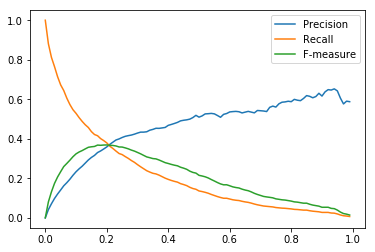

In [100]:
thresholds = [float(n) / nthresholds for n in range(0, nthresholds)]
falseposDict = dict([(t, falsepos(t)) for t in thresholds])
falsenegDict = dict([(t, falseneg(t)) for t in thresholds])
trueposDict = dict([(t, truepos(t)) for t in thresholds])

precisions = [precision(t) for t in thresholds]
recalls = [recall(t) for t in thresholds]
fmeasures = [fmeasure(t) for t in thresholds]

print precisions[0], fmeasures[0]
#assert (abs(precisions[0] - 0.000532546802671) < 0.0000001)
#assert (abs(fmeasures[0] - 0.00106452669505) < 0.0000001)


plt.plot(thresholds, precisions)
plt.plot(thresholds, recalls)
plt.plot(thresholds, fmeasures)
plt.legend(['Precision', 'Recall', 'F-measure'])
pass



In [101]:
graph = [(t, precision(t), recall(t),fmeasure(t)) for t in thresholds]
graphRDD = sc.parallelize(graph)

graphRow = graphRDD.map(lambda (t, x, y, z): Row(threshold=t, precision=x, recall=y, fmeasure=z))
graphDF = sqlContext.createDataFrame(graphRow)
graphDF.show()

+--------------------+--------------------+-------------------+---------+
|            fmeasure|           precision|             recall|threshold|
+--------------------+--------------------+-------------------+---------+
|0.001201975863400...|6.013493353933403E-4|                1.0|      0.0|
| 0.08115285203413236|0.042534238948892106| 0.8815384615384615|     0.01|
| 0.13242209542918051| 0.07208683186565636| 0.8123076923076923|     0.02|
|  0.1751452209118113| 0.09888690121248261| 0.7653846153846153|     0.03|
|  0.2075745726734443|  0.1214220363351196| 0.7146153846153847|     0.04|
| 0.23433315479378686| 0.14186121919584954| 0.6730769230769231|     0.05|
| 0.26012726990532364| 0.16293991833560179| 0.6446153846153846|     0.06|
|  0.2760070052539405| 0.17868480725623584| 0.6061538461538462|     0.07|
|  0.2924343394747158| 0.19621251972645976| 0.5738461538461539|     0.08|
|  0.3099695254680017|  0.2161505768063145| 0.5476923076923077|     0.09|
| 0.32445178024050936| 0.2339340360421